In [1]:
# import packages
import torch
import yfinance as yf
import numpy as np
import matplotlib.pyplot as plt
from qiskit_machine_learning.utils import algorithm_globals
from torch import nn
import pandas as pd
from scipy.stats import rankdata
import torch.nn.functional as F


In [2]:
#load dataset

sp500 = yf.download('AAPL', start='2010-01-01', end='2018-12-31')
dowjones = yf.download('MSFT', start='2010-01-01', end='2018-12-31')

# Compared to the Apple and Microsoft plot they have in the paper, this gives a similar result. To get it using amplitude encoding,
# we do need to preprocess the data as we were doing before, so putting it in a probability distribution.
sp500_returns = sp500['Close'].pct_change().dropna()
sp_returns = sp500['Close'].dropna().values

dowjones_returns = dowjones['Close'].pct_change().dropna()
dj_returns = dowjones['Close'].dropna().values


# encode in state amplitude
# We have 8192 datapoints, so we need 13 qubits to encode them
num_qubits = 3

[*********************100%***********************]  1 of 1 completed
[*********************100%***********************]  1 of 1 completed


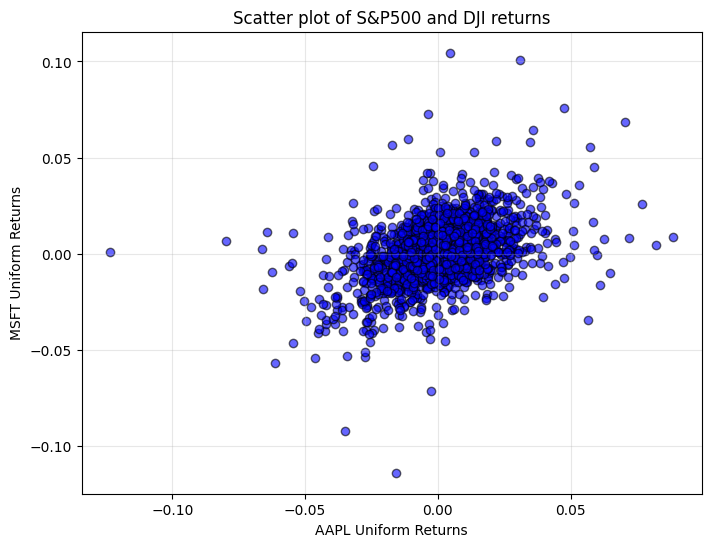

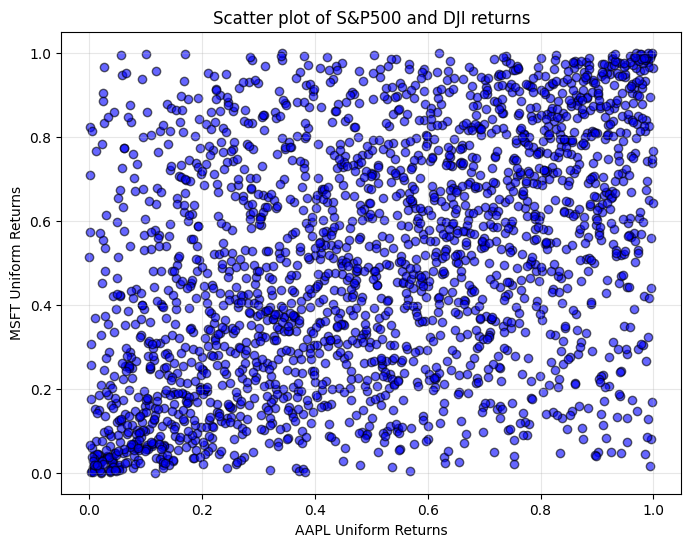

In [3]:
def empirical_cdf(data):
    ranks = rankdata(data, method='average')  # Rank the data
    uniform_data = ranks / (len(data) + 1)    # Normalize to [0, 1]
    return uniform_data

sp500_uniform = empirical_cdf(sp500_returns)
dj_uniform = empirical_cdf(dowjones_returns)

# Plot the scatter plot of returns
plt.figure(figsize=(8, 6))
plt.scatter(sp500_returns, dowjones_returns, alpha=0.6, c='blue', edgecolor='k')
plt.title("Scatter plot of S&P500 and DJI returns")
plt.xlabel("AAPL Uniform Returns")
plt.ylabel("MSFT Uniform Returns")
plt.grid(alpha=0.3)
plt.show()


# Plot the scatter plot of uniform returns
plt.figure(figsize=(8, 6))
plt.scatter(sp500_uniform, dj_uniform, alpha=0.6, c='blue', edgecolor='k')
plt.title("Scatter plot of S&P500 and DJI returns")
plt.xlabel("AAPL Uniform Returns")
plt.ylabel("MSFT Uniform Returns")
plt.grid(alpha=0.3)
plt.show()

In [4]:
data_stack = np.column_stack((sp500_uniform,dj_uniform))
df2 = pd.DataFrame({
    'SP500': sp500_uniform,
    'DJI': dj_uniform
})

In [5]:
from copulas.bivariate import Clayton

copulas = Clayton()
copulas.fit(data_stack)

samples = copulas.sample(len(data_stack))
samples = pd.DataFrame(samples, columns=['SP500', 'DJI'])
print(samples)

         SP500       DJI
0     0.835664  0.575267
1     0.268634  0.386977
2     0.869700  0.989519
3     0.580777  0.200092
4     0.728453  0.431729
...        ...       ...
2257  0.048444  0.070408
2258  0.699994  0.280774
2259  0.976172  0.785901
2260  0.115308  0.371127
2261  0.961483  0.666471

[2262 rows x 2 columns]


In [6]:
from copulas.visualization import compare_2d
compare_2d(df2, samples)

ValueError: Mime type rendering requires nbformat>=4.2.0 but it is not installed

Figure({
    'data': [{'hovertemplate': 'Data=Real<br>SP500=%{x}<br>DJI=%{y}<extra></extra>',
              'legendgroup': 'Real',
              'marker': {'color': '#000036', 'symbol': 'circle'},
              'mode': 'markers',
              'name': 'Real',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([0.53159523, 0.11533363, 0.41537782, ..., 0.99779054, 0.26292532,
                          0.49315068]),
              'xaxis': 'x',
              'y': array([0.49536014, 0.2691118 , 0.16173221, ..., 0.99779054, 0.69818825,
                          0.22138754]),
              'yaxis': 'y'},
             {'hovertemplate': 'Data=Synthetic<br>SP500=%{x}<br>DJI=%{y}<extra></extra>',
              'legendgroup': 'Synthetic',
              'marker': {'color': '#01E0C9', 'symbol': 'diamond'},
              'mode': 'markers',
              'name': 'Synthetic',
              'showlegend': True,
              'type': 'scattergl',
              'x': array([0.8356644 , 0.2686344 , 0.86969969, ..., 0.97617249, 0.11530766,
                          0.96148301]),
              'xaxis': 'x',
              'y': array([0.57526671, 0.386977  , 0.98951899, ..., 0.78590126, 0.37112721,
                          0.66647095]),
              'yaxis': 'y'}],
    'layout': {'font': {'size': 18},
               'legend': {'title': {'text': 'Data'}, 'tracegroupgap': 0},
               'margin': {'t': 60},
               'plot_bgcolor': '#F5F5F8',
               'showlegend': True,
               'template': '...',
               'title': {'text': "Real vs. Synthetic Data for columns 'SP500' and 'DJI'"},
               'xaxis': {'anchor': 'y', 'domain': [0.0, 1.0], 'title': {'text': 'SP500'}},
               'yaxis': {'anchor': 'x', 'domain': [0.0, 1.0], 'title': {'text': 'DJI'}}}
})

In [7]:
from qiskit import QuantumCircuit, QuantumRegister, transpile
from qiskit.circuit.library import RXXGate
def create_bell_pair_circuit(num_qubits=num_qubits):
    # Create two quantum registers A and B with num_qubits each
    qr_a = QuantumRegister(num_qubits, 'A')
    qr_b = QuantumRegister(num_qubits, 'B')
    qc = QuantumCircuit(qr_a, qr_b)

    # Step 1: Apply H gates to all qubits in register A
    qc.h(qr_a)

    # Step 2: Apply CNOT gates between corresponding qubits in A and B
    for i in range(num_qubits):
        qc.cx(qr_a[i], qr_b[i])

    return qc

In [8]:
# define generator
from qiskit_aer import AerSimulator

shots = 2048
class QCBM:
    def __init__(self, num_qubits, layers=1):
        self.num_qubits = num_qubits
        self.layers = layers
        self.params = np.random.uniform(0, 2 * np.pi, size=(layers, 2 * num_qubits))
        self.backend = AerSimulator()

    def set_params(self, params):
        # Update the generator's parameters
        self.params = params
        
    def build_circuit(self, params):
        from qiskit import QuantumCircuit, QuantumRegister
        from qiskit.circuit.library import RZGate, RXGate, CXGate

        # Ensure params are a NumPy array
        params = np.array(params)  # Ensure parameters are in NumPy format

        # Build a two-register circuit so the measurement yields 2*num_qubits bits:
        def add_unitary_layers(qc, qr, num_layers):
            num_qubits = len(qr)
            for layer in range(num_layers):
                for i in range(num_qubits):
                    qc.rz(float(params[layer, 2 * i]), qr[i])
                    qc.rx(float(params[layer, 2 * i + 1]), qr[i])
                for i in range(num_qubits - 1):
                    qc.append(RXXGate(float(params[layer, 2 * i])), [qr[i], qr[i+1]])
            return qc

        qr_a = QuantumRegister(self.num_qubits, 'A')
        qr_b = QuantumRegister(self.num_qubits, 'B')
        qc = create_bell_pair_circuit(self.num_qubits)
        qc = add_unitary_layers(qc, qr_a, self.layers)
        qc = add_unitary_layers(qc, qr_b, self.layers)
        qc.measure_all()
        return qc


    def run(self, params):
        circuit = self.build_circuit(params)
        circuit = transpile(circuit, backend=self.backend)
        job = self.backend.run(circuit, shots=shots)
        result = job.result()
        counts = result.get_counts()
        return counts

In [9]:
# define loss functions
def kl_divergence(p, q):
    epsilon = 1e-6  # Prevent division by zero
    p = np.clip(p, epsilon, 1.0)
    q = np.clip(q, epsilon, 1.0)
    return np.sum(p * np.log(p / q))

In [10]:
def spsa_gradient_estimator(C, theta_k, c, delta_k):
    """Estimate the gradient using SPSA."""
    perturbed_theta_plus = theta_k + c * delta_k
    perturbed_theta_minus = theta_k - c * delta_k

    # Compute the cost function for perturbed parameters
    C_plus = C(perturbed_theta_plus)
    C_minus = C(perturbed_theta_minus)

    # Debug: Print cost function values
    print(f"C_plus: {C_plus}, C_minus: {C_minus}")

    # Gradient estimator formula
    gradient_estimate = (C_plus - C_minus) / (2 * c * delta_k)

    # Debug: Check gradient estimate
    print("Gradient estimate:", gradient_estimate)
    return gradient_estimate

def spsa_update(theta_k, C, a, c, gamma, k):
    """Perform one step of SPSA update."""
    # Generate random perturbation vector delta_k
    delta_k = np.random.choice([-1, 1], size=len(theta_k))

    # Debug: Print shapes
    print("theta_k shape:", theta_k.shape)
    print("delta_k shape:", delta_k.shape)

    # Estimate the gradient using SPSA
    gradient_estimate = spsa_gradient_estimator(C, theta_k, c, delta_k)

    # Debug: Check gradient values
    print("Gradient estimate shape:", gradient_estimate.shape)

    # Update the parameter based on the SPSA update rule
    theta_k_plus_1 = theta_k - (a / k) * gradient_estimate

    # Debug: Check updated parameters
    print("Updated theta_k_plus_1:", theta_k_plus_1)
    return theta_k_plus_1
print("Samples shape:", samples.shape)

Samples shape: (2262, 2)


Min value in data_stack: 0.0004418912947414936
Max value in data_stack: 0.9995581087052585
theta_k shape: (1, 6)
delta_k shape: (1,)
C_plus: 0.21324878375134684, C_minus: 0.21341862215193202
Gradient estimate: [0.00849192]
Gradient estimate shape: (1,)
Updated theta_k_plus_1: [[0.98416811 5.62246385 6.06640146 4.44606945 2.84754585 5.30501108]]
Iteration 0/1000, KL Divergence: 0.213475
theta_k shape: (1, 6)
delta_k shape: (1,)
C_plus: 0.21345355802346977, C_minus: 0.21345371497186594
Gradient estimate: [-7.84741981e-06]
Gradient estimate shape: (1,)
Updated theta_k_plus_1: [[0.98416814 5.62246388 6.06640149 4.44606948 2.84754588 5.30501111]]
theta_k shape: (1, 6)
delta_k shape: (1,)
C_plus: 0.21374421975635421, C_minus: 0.2132047991822424
Gradient estimate: [0.02697103]
Gradient estimate shape: (1,)
Updated theta_k_plus_1: [[0.98409622 5.62239196 6.06632957 4.44599756 2.84747395 5.30493919]]
theta_k shape: (1, 6)
delta_k shape: (1,)
C_plus: 0.21357024980745232, C_minus: 0.2133843378065

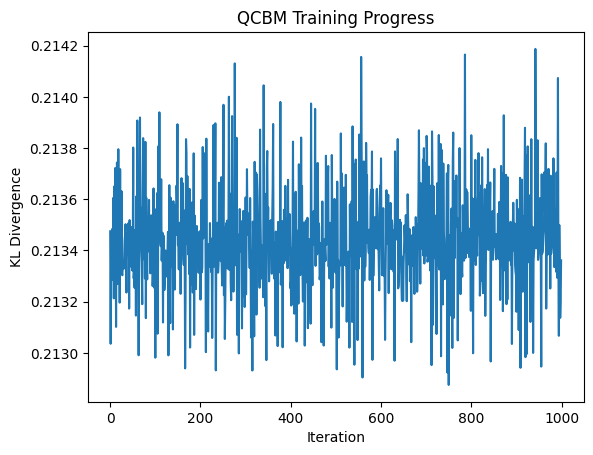

In [11]:
num_qubits_per_register = 3
layers = 1
qcbm = QCBM(num_qubits_per_register, layers)
a = 0.008
c = 0.01
gamma = 0.101

print("Min value in data_stack:", np.min(data_stack))
print("Max value in data_stack:", np.max(data_stack))
# Target distribution (normalized histogram of real data)
target_distribution = data_stack/29500

# Training Loop
num_iterations = 1000
cost_history = []

for iteration in range(num_iterations):
    # Generate data
    if len(target_distribution.shape) == 1:
        target_distribution = target_distribution.reshape(-1, 2)
    counts = qcbm.run(qcbm.params)
    generated_distribution = np.zeros_like(target_distribution)
    for bitstring, count in counts.items():
        idx = int(bitstring, 2)
        generated_distribution[idx] += count
    generated_distribution /= np.sum(generated_distribution)

    # Compute KL divergence
    cost = kl_divergence(target_distribution, generated_distribution)
    cost_history.append(cost)

    # Update parameters with SPSA
    def loss_fn(params):
        counts = qcbm.run(params)
        generated_distribution = np.zeros_like(target_distribution)
        for bitstring, count in counts.items():
            idx = int(bitstring, 2)
            generated_distribution[idx] += count
        generated_distribution /= np.sum(generated_distribution)
        return kl_divergence(target_distribution, generated_distribution)

    qcbm.params = spsa_update( qcbm.params,loss_fn,a, c, gamma, iteration + 1)

    if iteration % 10 == 0:
        print(f"Iteration {iteration}/{num_iterations}, KL Divergence: {cost:.6f}")

hist, edges = np.histogramdd(data_stack, bins=16, density=True)
t_distribution = hist.flatten() / np.sum(hist)
print("Target distribution sum:", np.sum(t_distribution))
# Plot the cost function
plt.plot(range(num_iterations), cost_history)
plt.xlabel("Iteration")
plt.ylabel("KL Divergence")
plt.title("QCBM Training Progress")
plt.show()